In [1]:

import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import os
import pickle
import glob
%matplotlib inline

In [2]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)
def getValues(files,skip,nFiles=-1,findex=0,single=False,prnt=False):
    theone={}
    if(single):
        values={"time":np.array([]),"voltage":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["time"]=np.append(values["time"],float(splitline[0]))
                values["voltage"]=np.append(values["voltage"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"time":np.array([]),"voltage":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    next(f)
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                print(f"Analyzing Following Files ---> {k}")
                break

    return theone

def Histogram(data,xlabel,ylabel,title,figsize=(12,8),dpi=300,bins=3):
    plt.figure(figsize=figsize,dpi=dpi)
    plt.hist(data,bins=bins)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
def WriteToFile(x,y,txtfile):
    with open(txtfile,"w") as f:
        for i in range(0,len(x)):
            s=str(x[i]) + " " +str(y[i]) +"\n"
            f.write(s)

def getArea(pmt,xlow,xhigh,minpulse=9999,gain=0,p=True):
 
    ### This is for removing DC offset
    MaskTime=pmt["time"]<=xlow
    DataNoOffset=pmt["voltage"]-st.mean(pmt["voltage"][MaskTime])
    datamin=np.min(DataNoOffset)
    if(datamin>=minpulse and minpulse!=9999): return -1
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(pmt["time"],DataNoOffset,label="Signal DC-removed")
        plt.plot(pmt["time"],pmt["voltage"],label="Signal")
        plt.axvline(xlow)
        plt.axvline(xhigh)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.legend()
        plt.show()

    DataMask=np.where(np.logical_and(pmt["time"]>=xlow,pmt["time"]<=xhigh))
    x=pmt["time"][DataMask]
    y=DataNoOffset[DataMask]
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.plot(x,y)
        plt.show()

    dt=pmt["time"][DataMask][1:]-pmt["time"][DataMask][:-1]
    area=abs(np.trapz(DataNoOffset[DataMask],dx=dt))
    if(gain):
        PE=NumofPE(area,50,gain,1.62e-19)
        
    
    return area,PE

def MultiAreaPE(data,xlow,xhigh,minpulse,g,p=False):
    area=np.array([])
    PE=np.array([])
    for key in data:
        result=getArea(data[key],xlow,xhigh,minpulse=minpulse,gain=g,p=p)
        if(result!=-1):
            area=np.append(area,result[0])
            PE=np.append(PE,result[1])
    values=np.array([area,PE])
    
    return values
def ListofFiles(path):
    Ch1filelist=[]
    Ch2filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
            #append the file name to the list
            if(file[:2]=="C2"):
                Ch2filelist.append(os.path.join(root,file))
            elif(file[:2]=="C1"):
                Ch1filelist.append(os.path.join(root,file))
    return Ch1filelist,Ch2filelist
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getSimValues(files,weight):
    values={"S1_PHOTOCATHODE":np.array([]),"S2_PHOTOCATHODE":np.array([])}
    for i in files:
        count=0
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values[splitline[0]]=np.append(values[splitline[0]],round(int(splitline[1])/weight))
        f.close()
        
    return values

def getValues_extra(files,weight):
    values={}
    for i in files:
        count=0
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                #print(splitline)
                if(splitline[0] in values.keys()):
                    values[splitline[0]]=np.append(values[splitline[0]],round(int(splitline[1])/weight))
                else:
                    values[splitline[0]]=np.array(round(int(splitline[1])/weight))
                    
        f.close()
        
    return values

def getValuesWithSource(files,weight):
    values={}

    for i in files:
        count=0
        sources={}
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                if(splitline[0] in values.keys()):
                    if(splitline[1] in values[splitline[0]].keys()):
                        values[splitline[0]][splitline[1]]=np.append(values[splitline[0]][splitline[1]],round(int(splitline[2])/weight))
                    else:
                        sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                        values[splitline[0]][splitline[1]]=sources[splitline[1]]
                else:
                    sources={}
                    sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                    values[splitline[0]]=sources
        f.close()
        
    return values


### Photons

## point Source
Point_SolidAngle=lambda r,R:(r**2/(4*R**2))

## Disk Source
Disk_SolidAngle=lambda A,B:(B**2/4)*(1-3/4*(A**2+B**2)+15/8*(1/3*(A**4+B**4)+(A*B)**2)-35/16*(1/4*(A**6+B**6)+3/2*(A*B)**2*(A**2+B**2)))

        

In [3]:
### Gains ###
IlkersGains=[3.9e6,2.6e6]
NicksGains=[3.4e6,2.2e6]
#NicksGains=[4.57e6,2.2e6]
DrBrandtGains=[2.5e6,3.8e6]

In [4]:
Ch1=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/S2")[0]
Ch2=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/S2")[1]
Path="/media/ilker/Ilker/CRAB/Analysis/old/CRAB/Main/SimAnalysis/"


In [5]:
ch1dd=getValues(Ch2,5,nFiles=2000,single=False,prnt=False)
#ch1dd=getValues(Ch1,5,nFiles=1000,single=False,prnt=False)


Analyzing Following Files ---> /media/ilker/Ilker/CRAB/07.09.22/S2/1/C2s202020.csv


key is 1 and PE is 230.4371050175352
key is 2 and PE is 205.57792279984918
key is 8 and PE is 589.4295910205649
key is 19 and PE is 202.36615861457105
key is 23 and PE is 284.87884122247743
key is 34 and PE is 538.6646178254678
key is 44 and PE is 874.8284388803619
key is 46 and PE is 223.45153191959884
key is 52 and PE is 272.9770411385466
key is 55 and PE is 324.35698788353506
key is 61 and PE is 884.5181602922921


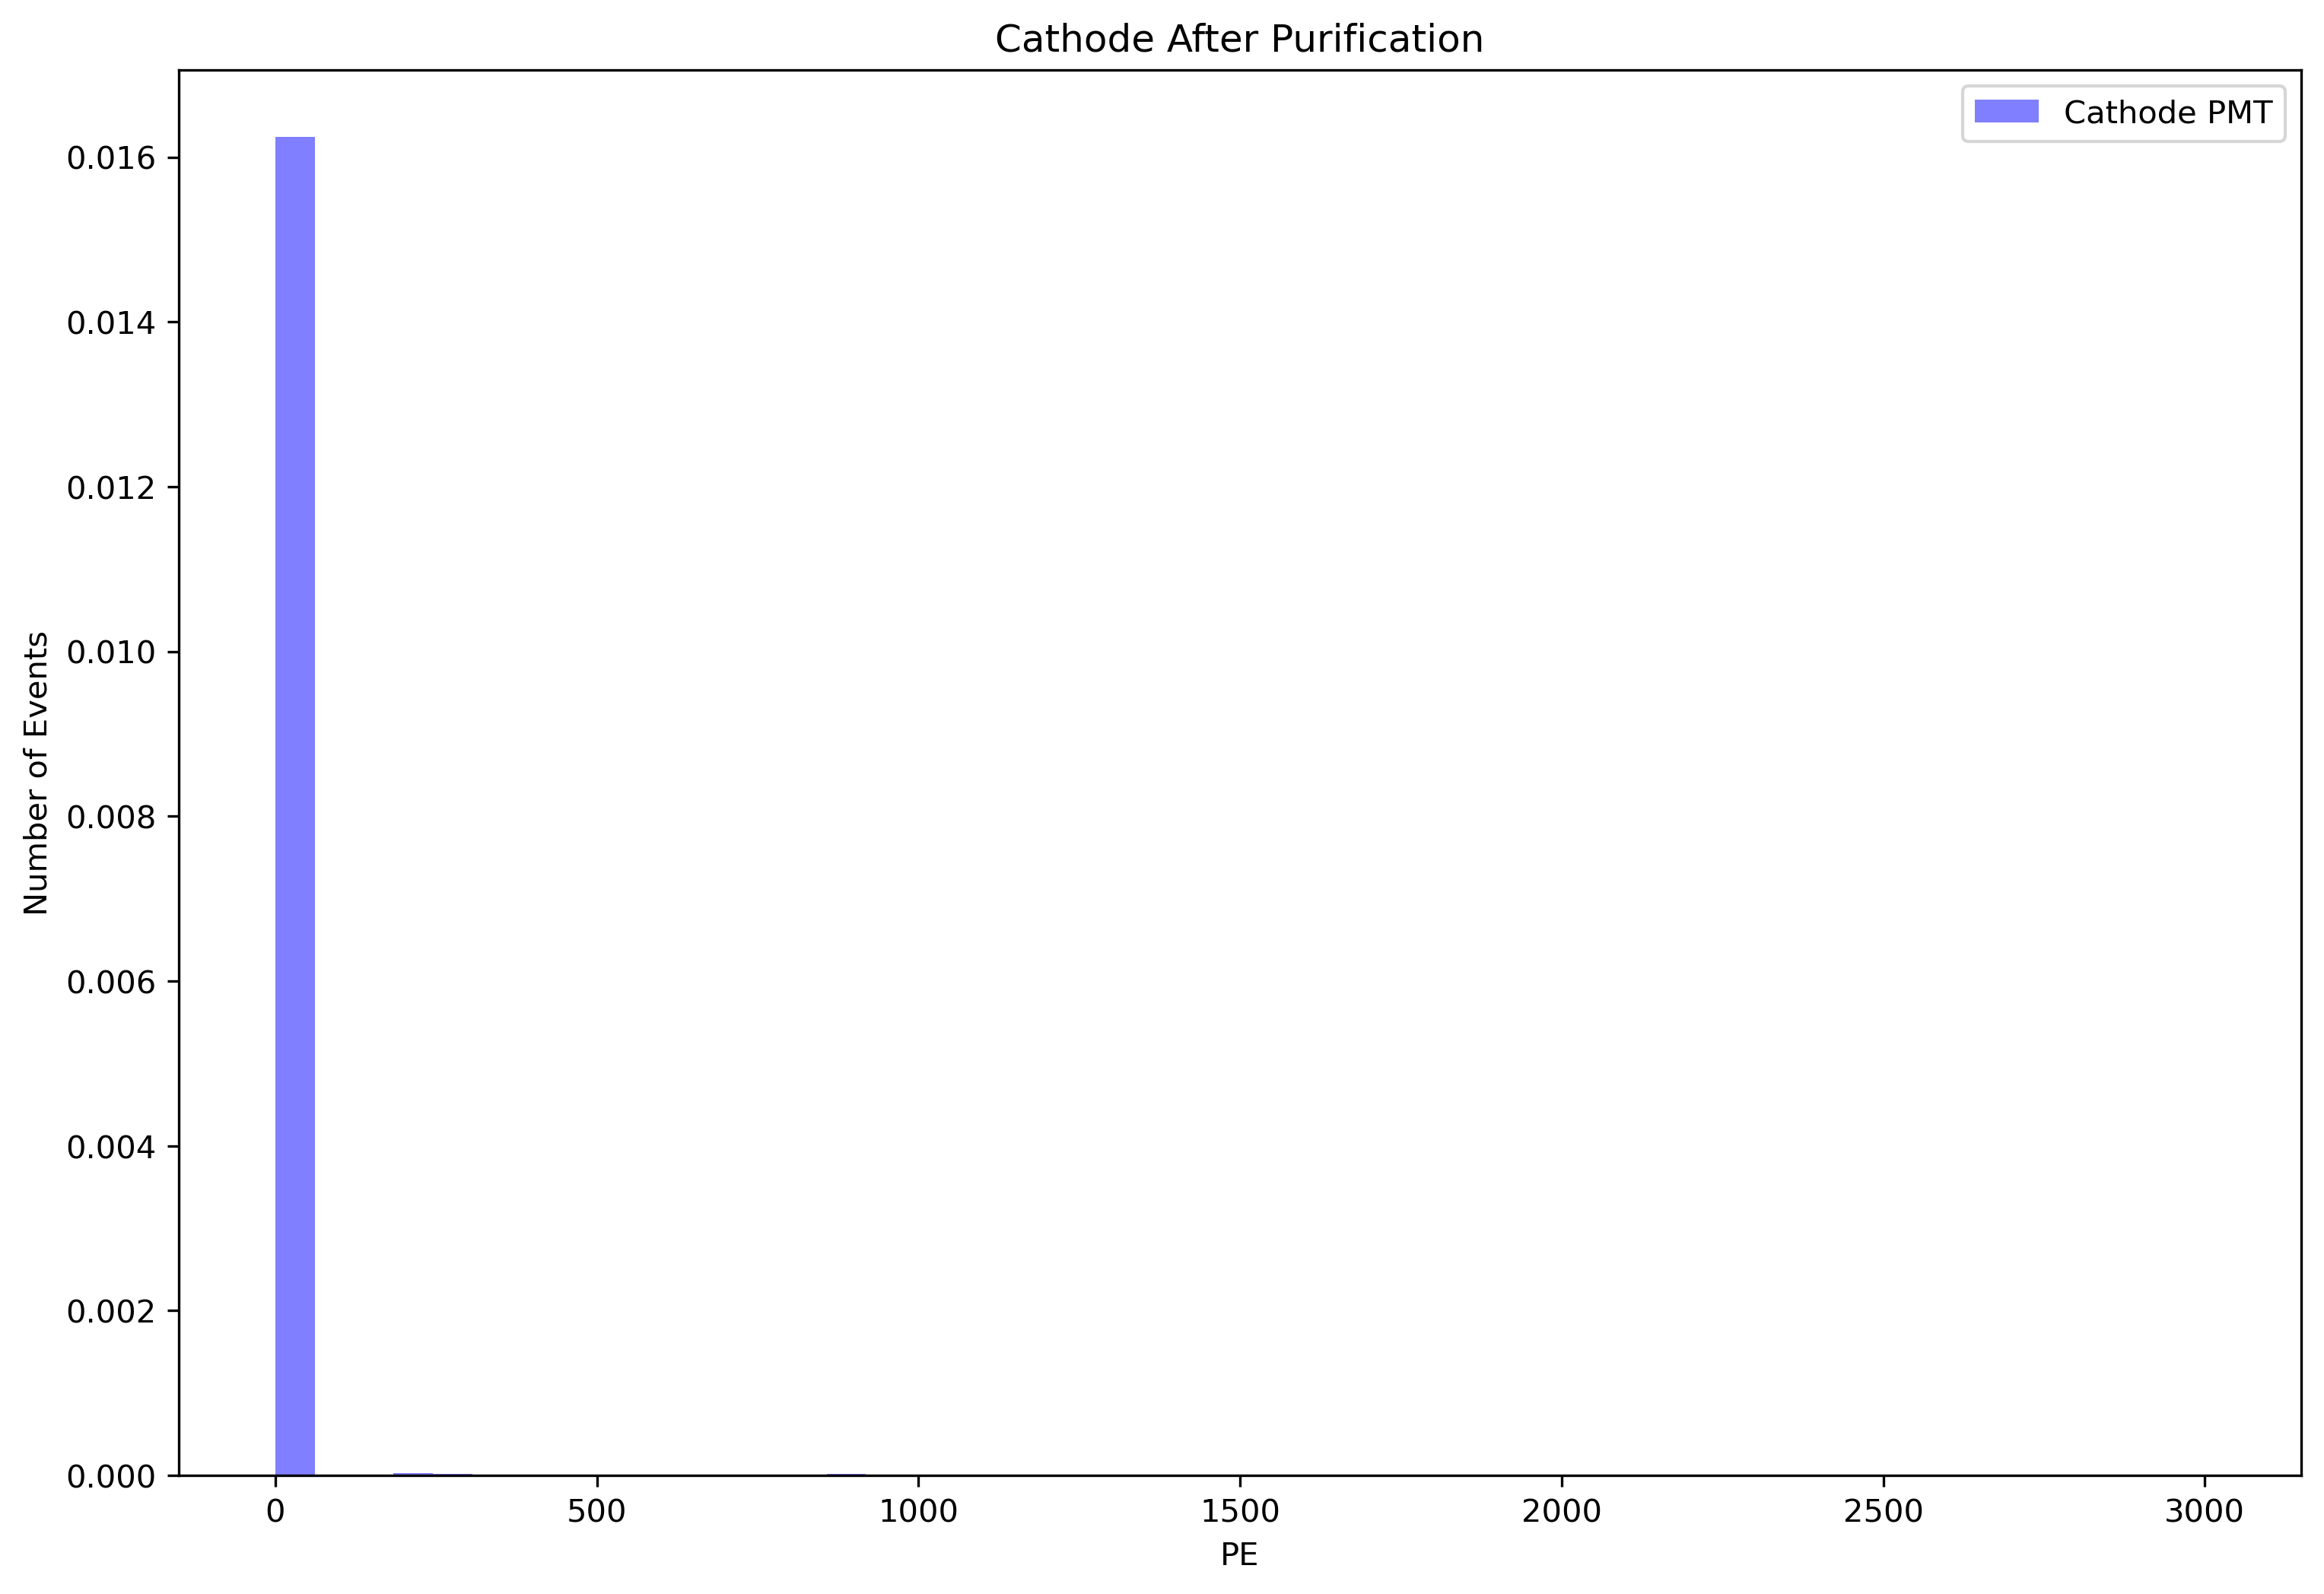

In [27]:
kk=np.zeros(len(ch1dd))
count=0
innercount=0
for i in ch1dd:
    k=getArea(ch1dd[i],-4e-5,1e-5,minpulse=-0.0004,gain=IlkersGains[1],p=False)
    if(k!=-1):
        if(k[1]>200 and k[1]<=1000):
            kk[count]=k[1]
            print(f"key is {i} and PE is {k[1]}")
            if (innercount==10): break
            innercount=innercount+1
    count=count+1
binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode After Purification")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(kk,bins=binss,density=True,stacked=True,label="Cathode PMT",color="b",alpha=0.5)
plt.legend()
plt.show()

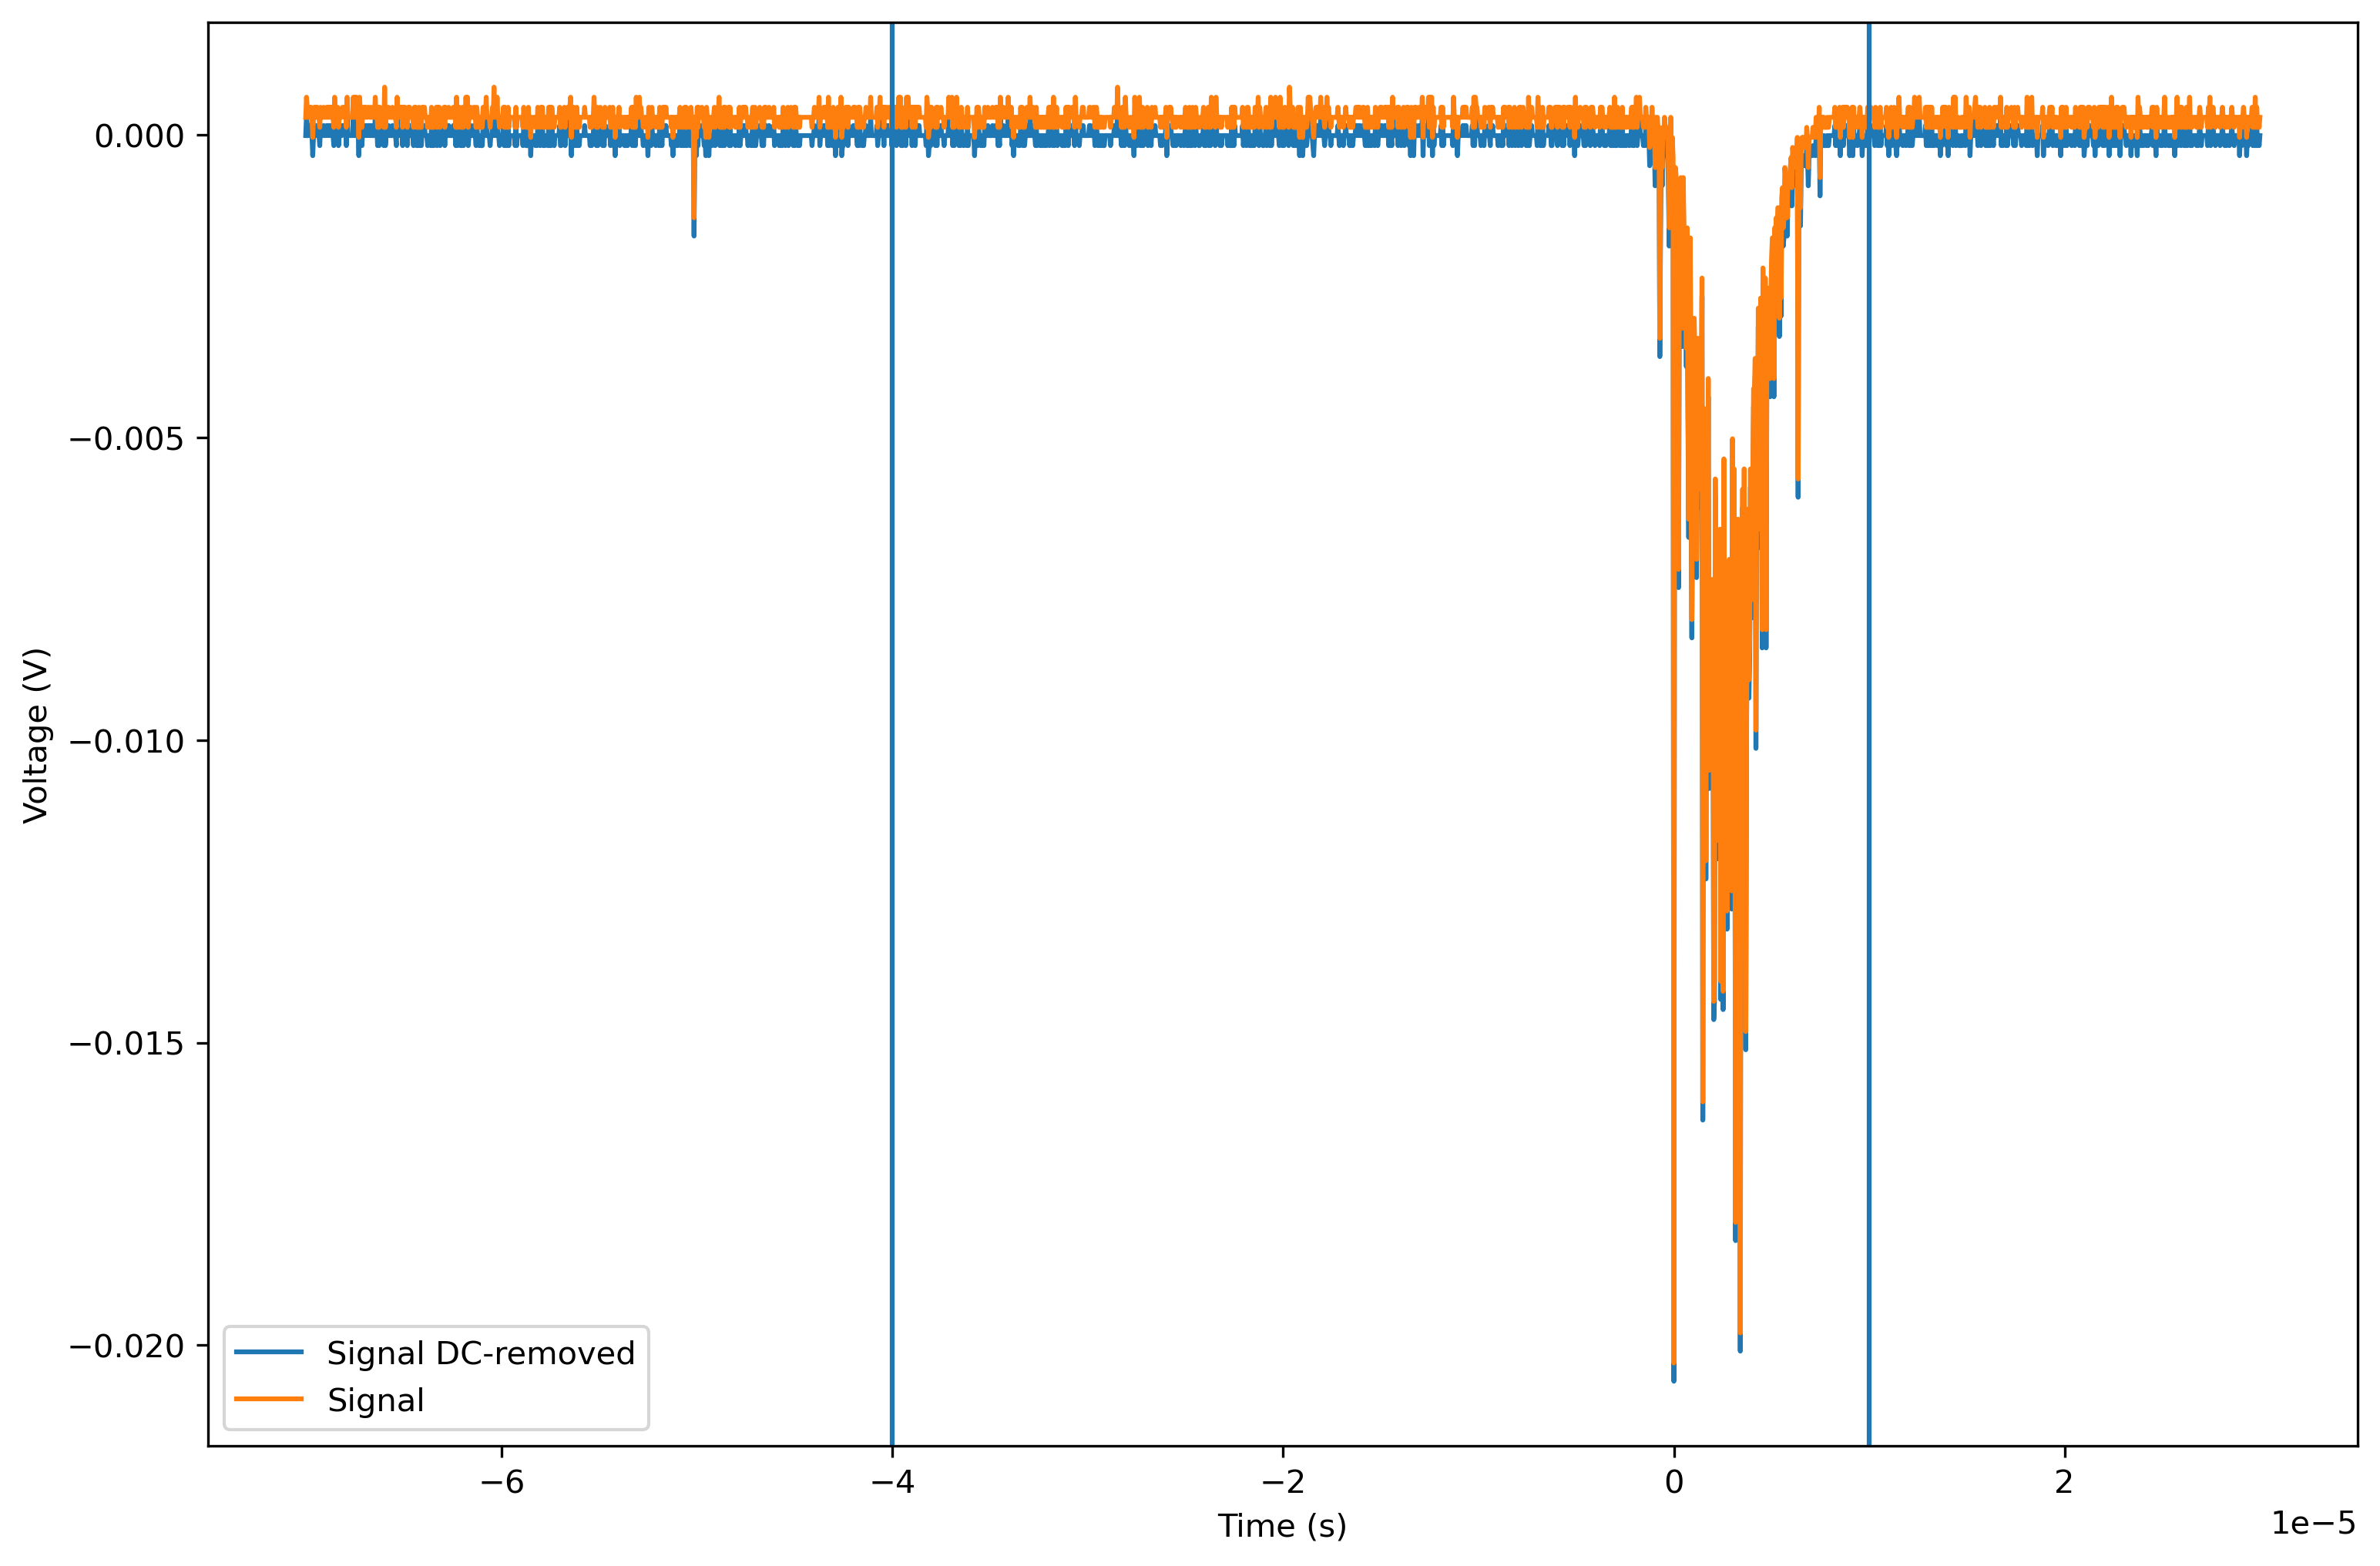

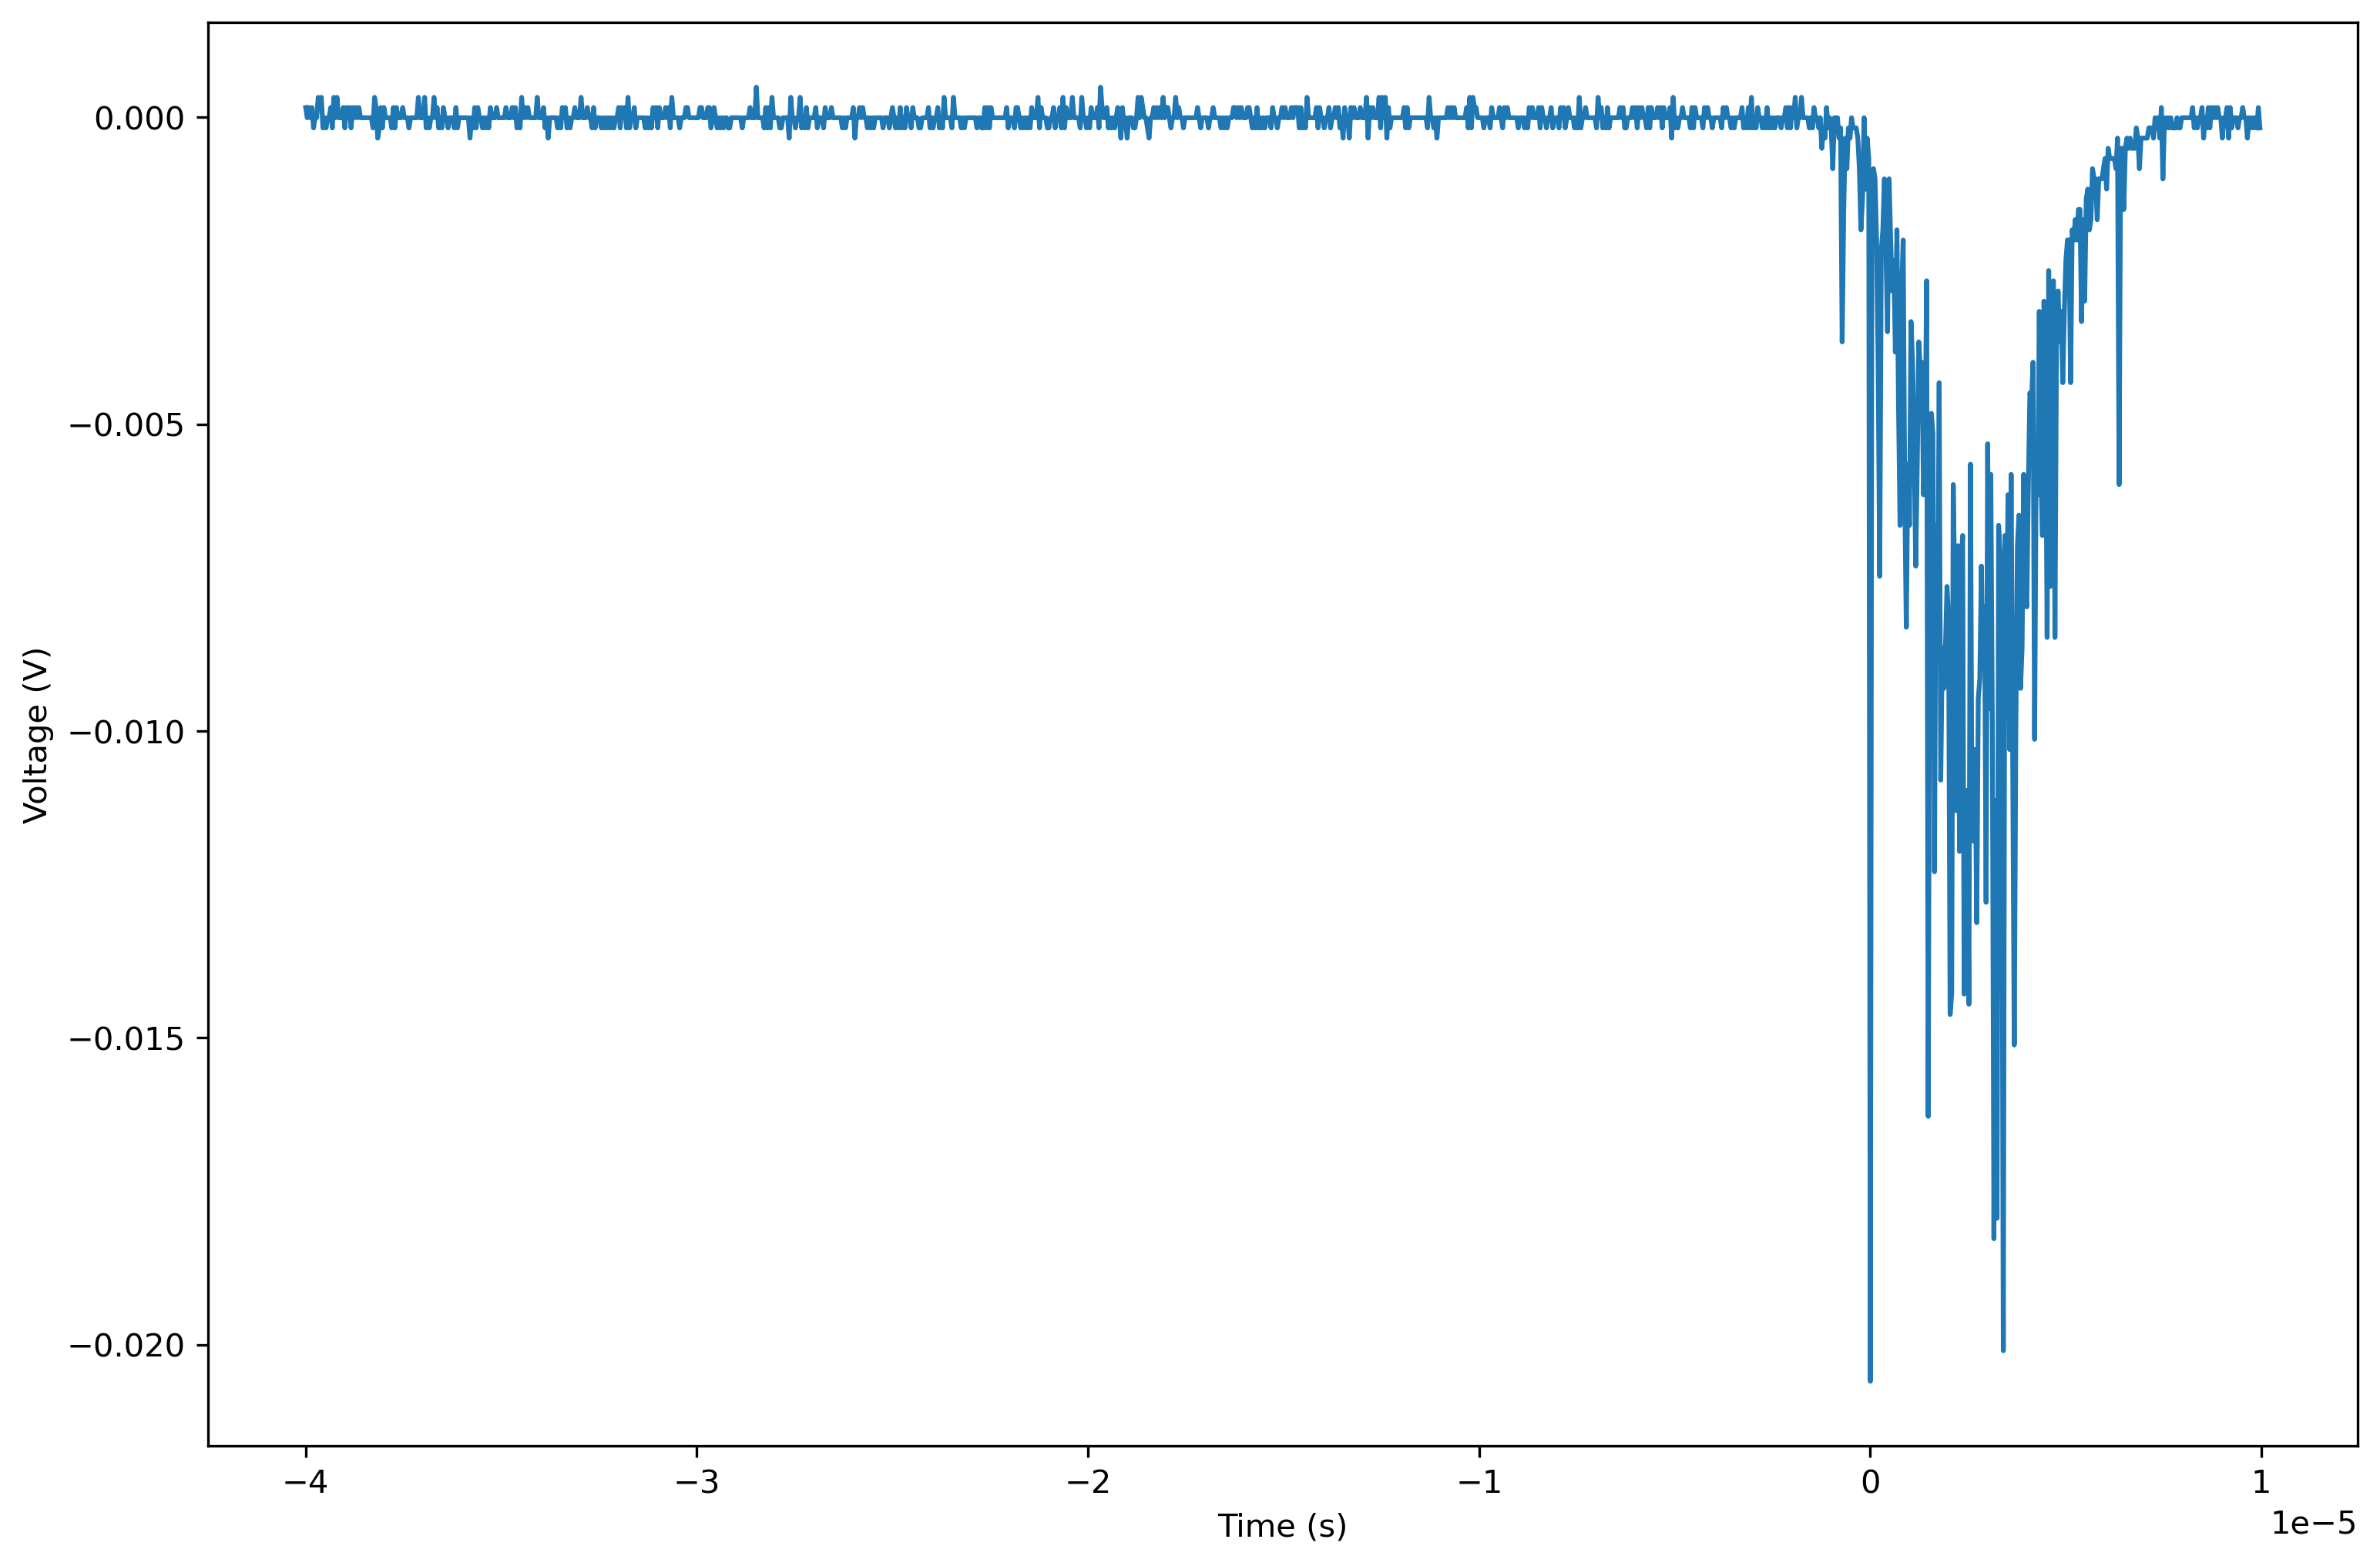

(3.9122080112880193e-08, 1857.6486283418892)

In [7]:
getArea(ch1dd[282],-4e-5,1e-5,minpulse=-0.0004,gain=IlkersGains[1],p=True)

In [8]:
##### SIM S2 ####
SimPath="/media/ilker/Ilker/CRAB/07_20_2022/S2_counts/*.txt"

S2files = glob.glob(SimPath,recursive=True)
S2=getSimValues(S2files,1)

#Histogram(S2["S1_PHOTOCATHODE"],"PhotoElectrons","# Events","PMT3_S2",bins=50)
PMT1_S2_mean=st.mean(S2["S2_PHOTOCATHODE"])
PMT1_S2_stdev=st.stdev(S2["S2_PHOTOCATHODE"])
PMT3_S1_mean=st.mean(S2["S1_PHOTOCATHODE"])


In [9]:
if(not(os.path.exists(Path+"R2_Ch1_data.p"))): 
    Ch1data=getValues(Ch1,5,single=False,prnt=False)
    PickleITDump(Ch1data,Path+"R2_Ch1_data.p")
else:
    Ch1data=PickleITRead(Path+"R2_Ch1_data.p")

if(not(os.path.exists(Path+"R2_Ch2_data.p"))):
    Ch2data=getValues(Ch2,5,single=False,prnt=False)
    PickleITDump(Ch2data,Path+"R2_Ch2_data.p")
else:
    Ch2data=PickleITRead(Path+"R2_Ch2_data.p")


In [10]:
Ch1AreaPEIlker=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=99999,g=IlkersGains[0],p=False)
Ch2AreaPEIlker=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=99999,g=IlkersGains[1],p=False)
#Ch1AreaPENick=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=NicksGains[0],p=False)
#Ch1AreaPEDrBrantdsLab=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)



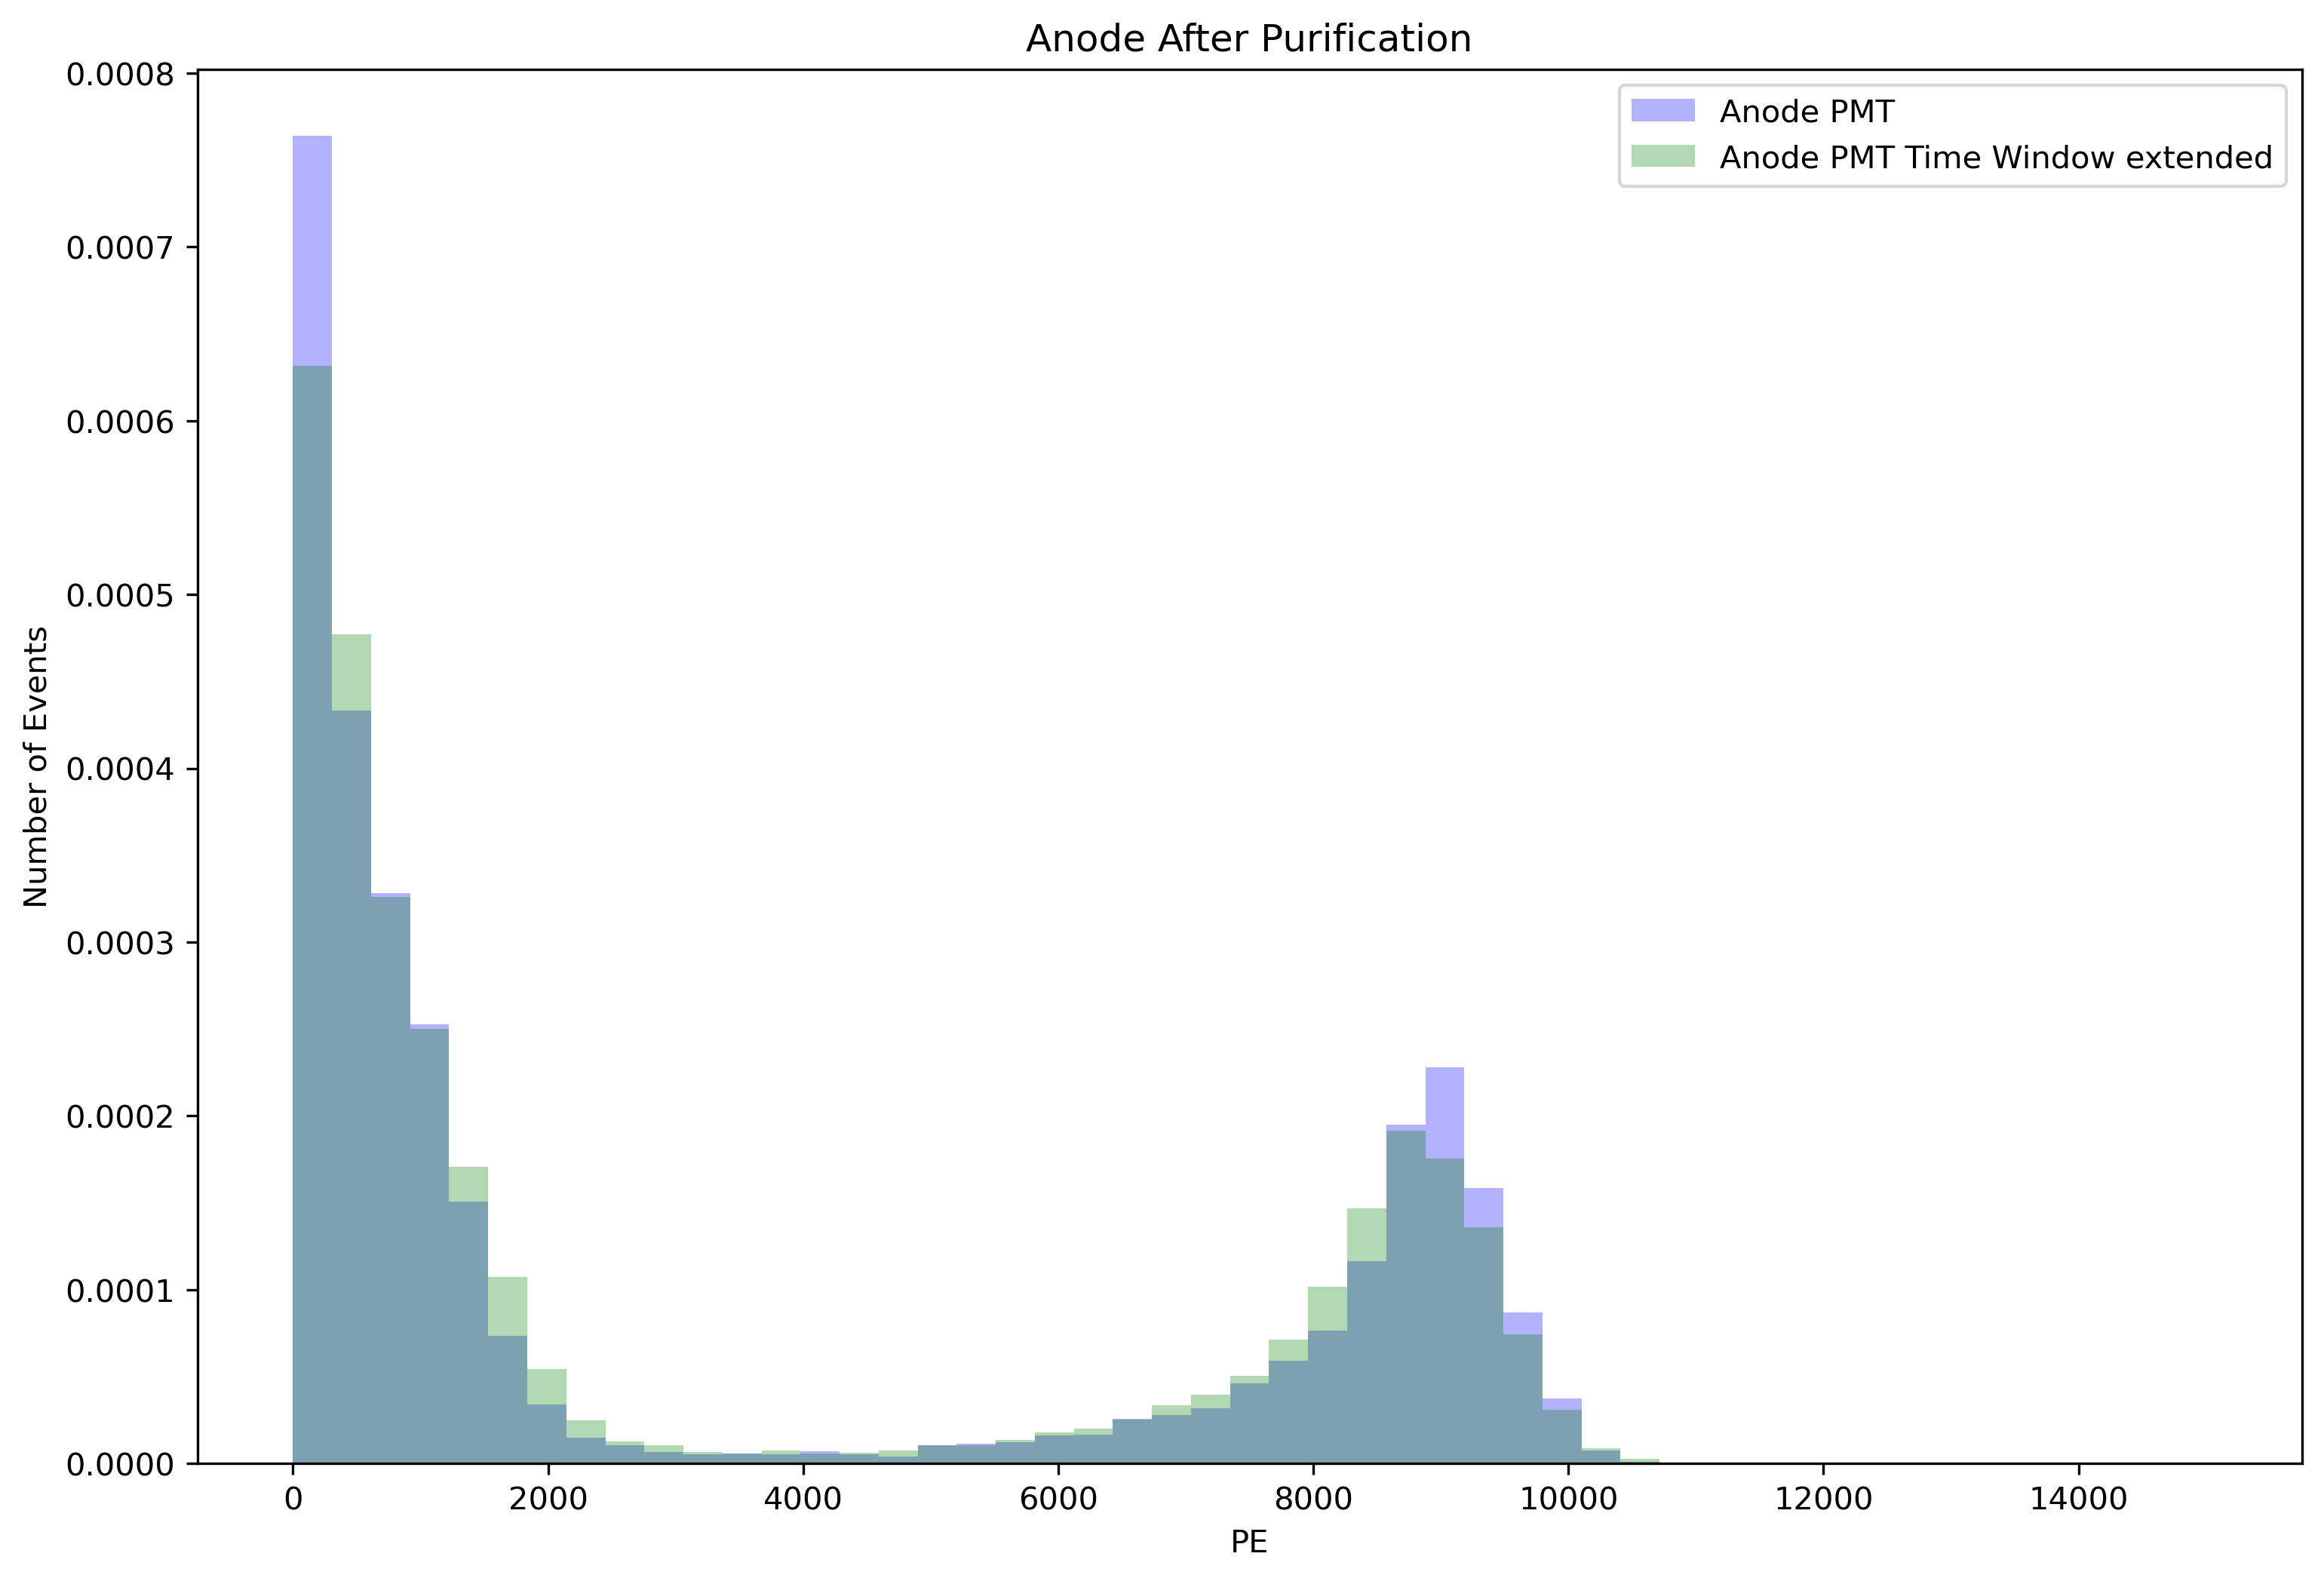

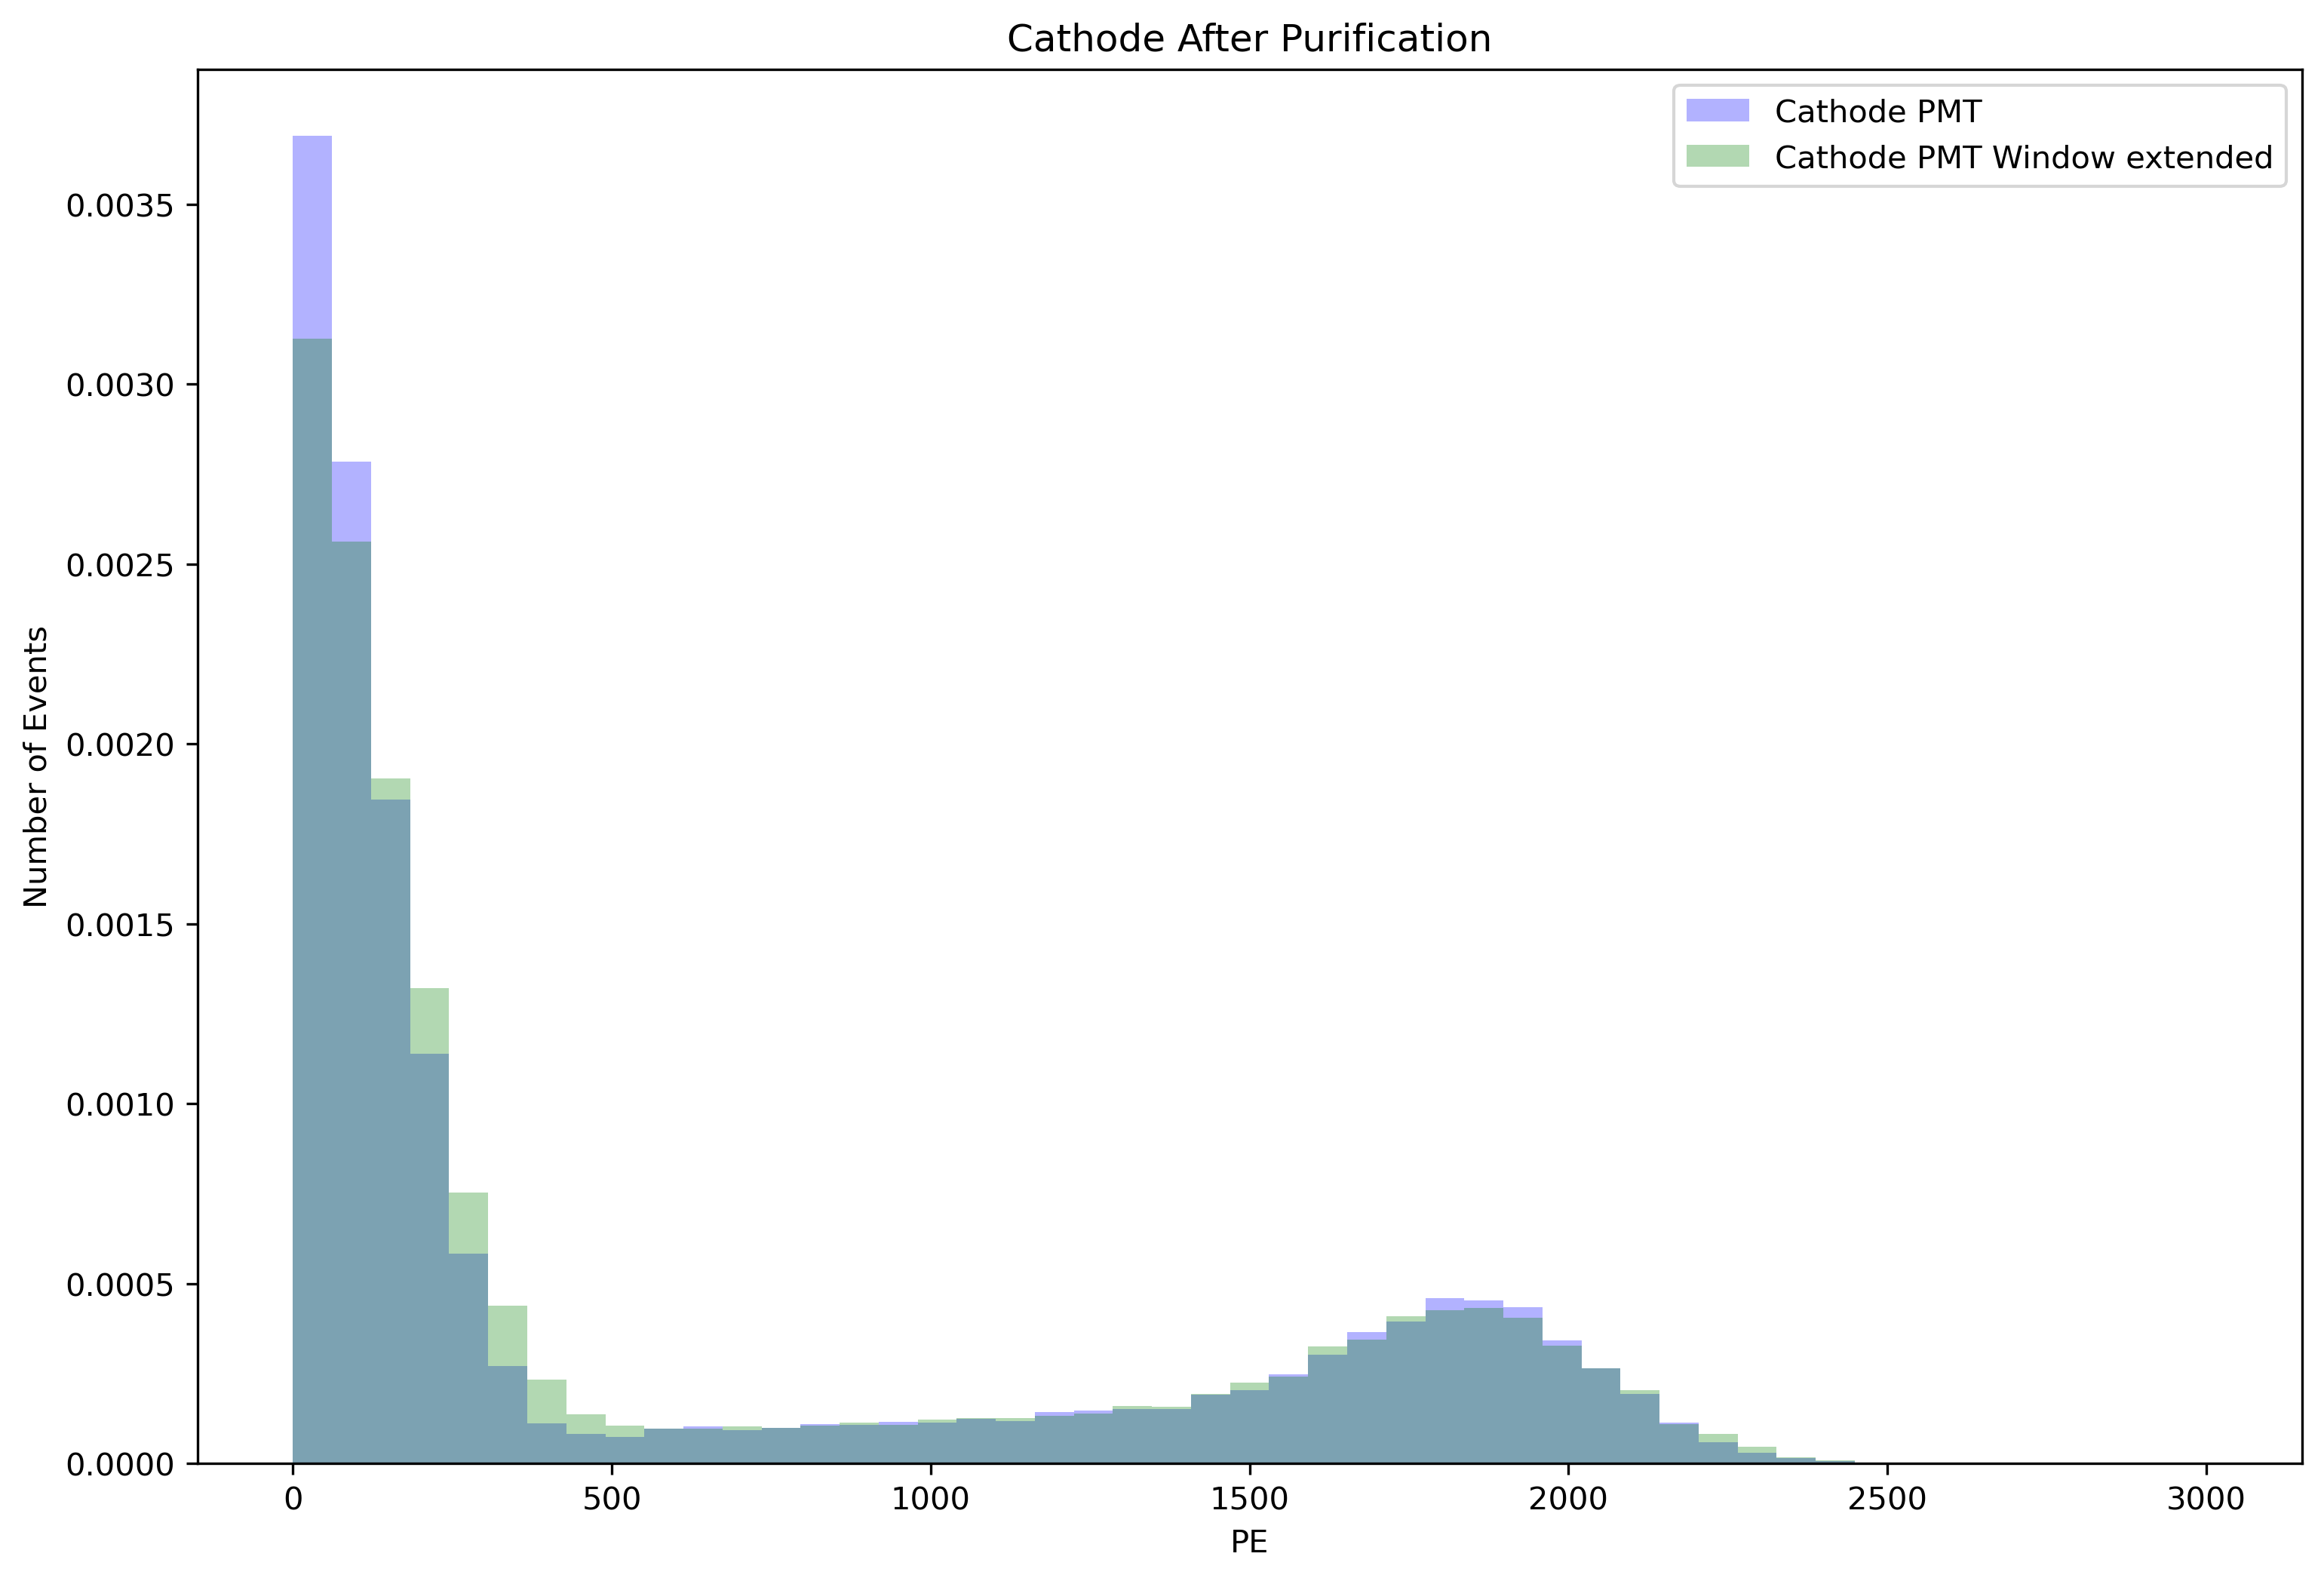

In [11]:
binss=np.linspace(0,15000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Anode After Purification")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Ch1AreaPEIlker[1],bins=binss,density=True,stacked=True,label="Anode PMT",color="b",alpha=0.3)

plt.legend()
plt.show()
binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode After Purification")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Ch2AreaPEIlker[1],bins=binss,density=True,stacked=True,label="Cathode PMT",color="b",alpha=0.3)

plt.legend()
plt.show()

In [12]:
#Ch2AreaPE=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=Gains[1],p=False)
Ch2AreaPEIlker=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=-0.0004,g=IlkersGains[1],p=False)
Ch2AreaPENick=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=NicksGains[1],p=False)
Ch2AreaPEDrBrantdsLab=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[1],p=False)

In [13]:
print(Path+"Run1_Ch1_S2data.p")


/media/ilker/Ilker/CRAB/Analysis/old/CRAB/Main/SimAnalysis/Run1_Ch1_S2data.p


In [14]:
###################### Run 2 ###################################
Run1_Ch1=ListofFiles("//media/ilker/Ilker/CRAB/07.08.22/S2")[0]
Run1_Ch2=ListofFiles("/media/ilker/Ilker/CRAB/07.08.22/S2")[1]
Run2QuickCh1=getValues(Run1_Ch1,5,nFiles=20,single=False,prnt=False)


Analyzing Following Files ---> //media/ilker/Ilker/CRAB/07.08.22/S2/1/C1s2-bothPMTs00025.csv


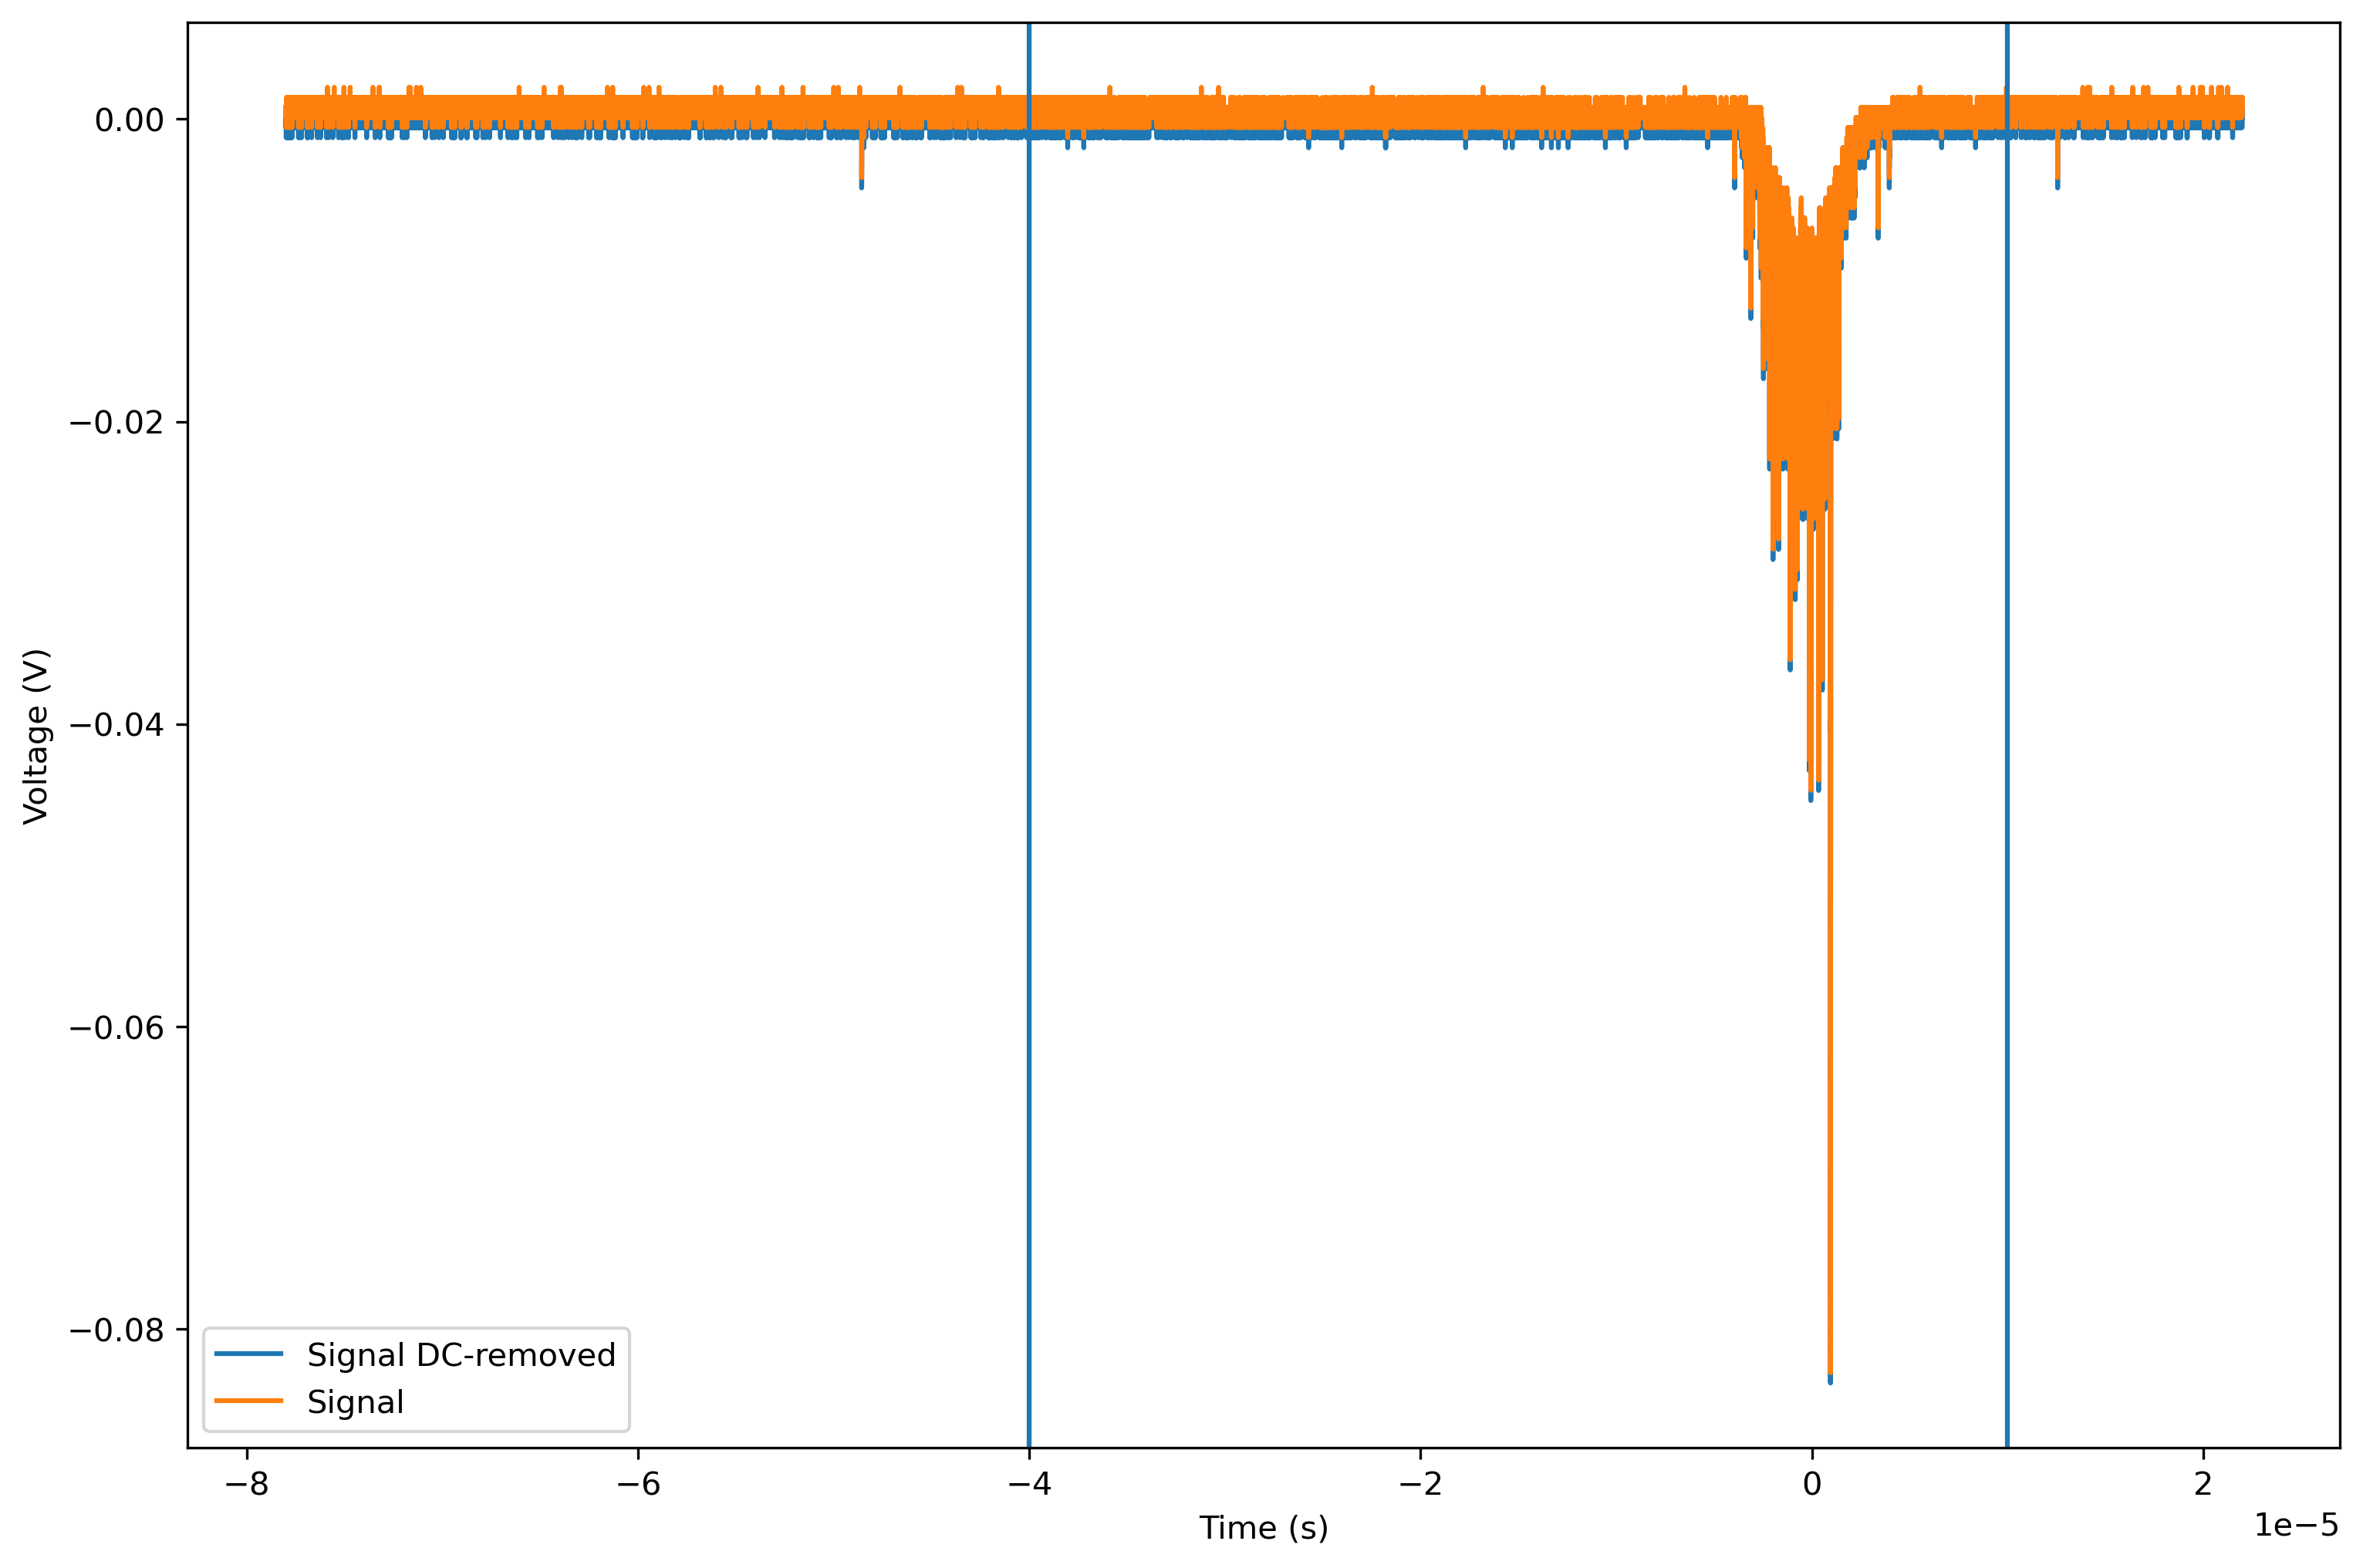

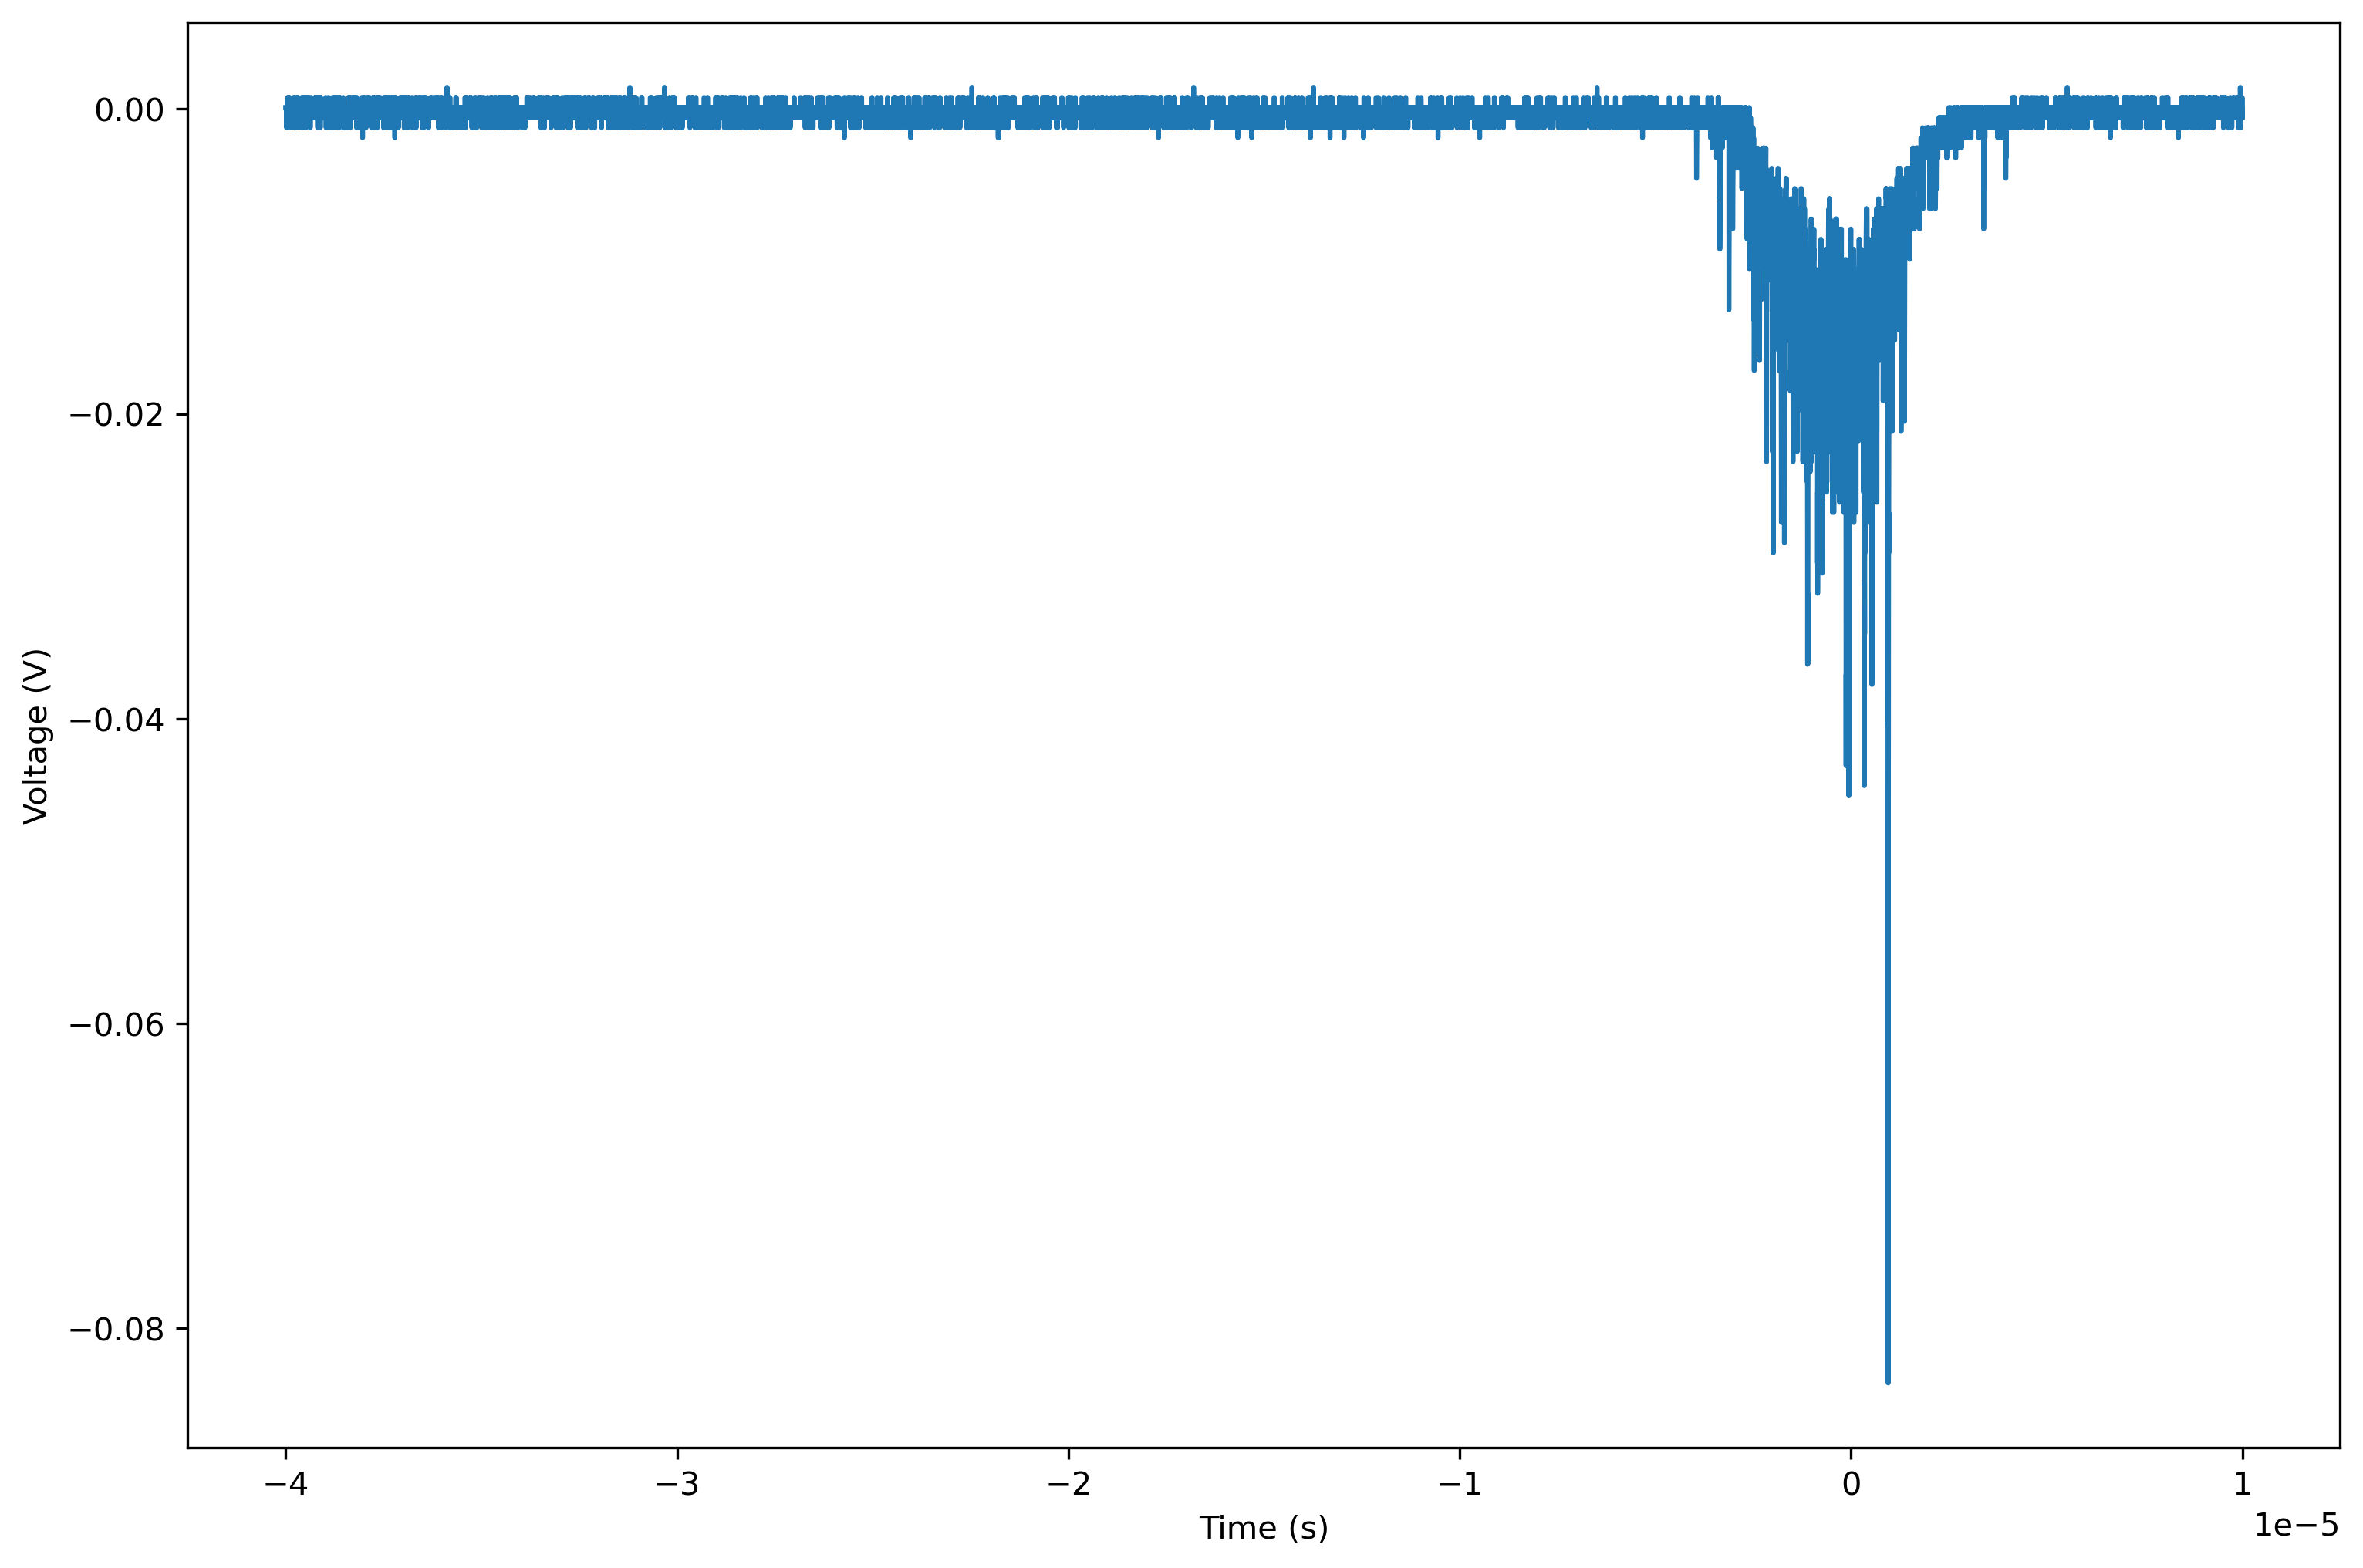

(6.18274803456668e-08, 3053.208905958854)

In [15]:
getArea(Run2QuickCh1[12],-4e-5,1e-5,minpulse=-0.003,gain=DrBrandtGains[0],p=True)


In [16]:
if(not(os.path.exists(Path+"Run1_Ch1_S2data.p"))): 
    Run1_Ch1data=getValues(Run1_Ch1,5,single=False,prnt=False)
    PickleITDump(Run1_Ch1data,Path+"Run1_Ch1_S2data.p")
else:
    Run1_Ch1data=PickleITRead(Path+"Run1_Ch1_S2data.p")
    
if(not(os.path.exists(Path+"Run1_Ch2_S2data.p"))):
    Run1_Ch2data=getValues(Run1_Ch2,5,single=False,prnt=False)
    PickleITDump(Run1_Ch2data,Path+"Run1_Ch2_S2data.p")
else:
    Run1_Ch2data=PickleITRead(Path+"Run1_Ch2_S2data.p")

In [28]:
################### Run1 Comp ########################
#### Ch1 ####
#Run1_Ch1AreaPEIlker=MultiAreaPE(Run1_Ch1data,-4e-5,5e-5,minpulse=-0.0004,g=IlkersGains[0],p=False)
#Run1_Ch1AreaPENick=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=NicksGains[0],p=False)
#Run1_Ch1AreaPEDrBrantdsLab=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)
#### Ch2 ####

#Run1_Ch2AreaPEIlker=MultiAreaPE(Run1_Ch2data,-4e-5,5e-5,minpulse=-0.0004,g=IlkersGains[0],p=False)
#Run1_Ch2AreaPENick=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=NicksGains[0],p=False)
#Run1_Ch2AreaPEDrBrantdsLab=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)



'''values={"Day2_Anode":MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0],
        "Day2_Cathode":MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0],
        "Day1_Anode":MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0],
        "Day1_Cathode":MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0]}
PickleITDump(values,"Area_old.p")'''

'values={"Day2_Anode":MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0],\n        "Day2_Cathode":MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0],\n        "Day1_Anode":MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0],\n        "Day1_Cathode":MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=99999,g=1,p=False)[0]}\nPickleITDump(values,"Area_old.p")'

In [18]:
#Run1_Ch1AreaPE=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)
#Run1_Ch2AreaPE=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)


In [19]:
'''plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1")
plt.ylabel("Number of Events")
plt.xlabel("PE")
#plt.hist(S2["S2_PHOTOCATHODE"],bins=100,density=True,stacked=True,label="S2_Sim",color="g")
plt.hist(Run1_Ch1AreaPE[1],bins=100,density=True,stacked=True,label="S2_Day1_Data",color="b")
plt.legend()
plt.show()
#plt.semilogy()
mean=st.mean(Run1_Ch1AreaPE[1])
stdev=st.stdev(Run1_Ch1AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")
'''

'plt.figure(figsize=(12,8),dpi=300)\nplt.title("PMT1")\nplt.ylabel("Number of Events")\nplt.xlabel("PE")\n#plt.hist(S2["S2_PHOTOCATHODE"],bins=100,density=True,stacked=True,label="S2_Sim",color="g")\nplt.hist(Run1_Ch1AreaPE[1],bins=100,density=True,stacked=True,label="S2_Day1_Data",color="b")\nplt.legend()\nplt.show()\n#plt.semilogy()\nmean=st.mean(Run1_Ch1AreaPE[1])\nstdev=st.stdev(Run1_Ch1AreaPE[1])\nprint(f"Area mean = {mean} stdev = {stdev}")\n'

In [20]:
'''plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3")
plt.ylabel("Number of Events")
plt.xlabel("PE")
#plt.hist(S2["S1_PHOTOCATHODE"],bins=100,density=True,stacked=True,label="S2_Sim",color="g")
plt.hist(Run1_Ch2AreaPE[1],bins=100,density=True,stacked=True,label="S2_Day1_Data",color="b")
plt.legend()
plt.show()
#plt.semilogy()
mean=st.mean(Run1_Ch2AreaPE[1])
stdev=st.stdev(Run1_Ch2AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")
'''

'plt.figure(figsize=(12,8),dpi=300)\nplt.title("PMT3")\nplt.ylabel("Number of Events")\nplt.xlabel("PE")\n#plt.hist(S2["S1_PHOTOCATHODE"],bins=100,density=True,stacked=True,label="S2_Sim",color="g")\nplt.hist(Run1_Ch2AreaPE[1],bins=100,density=True,stacked=True,label="S2_Day1_Data",color="b")\nplt.legend()\nplt.show()\n#plt.semilogy()\nmean=st.mean(Run1_Ch2AreaPE[1])\nstdev=st.stdev(Run1_Ch2AreaPE[1])\nprint(f"Area mean = {mean} stdev = {stdev}")\n'

In [21]:
'''values={"Day2_Ch1Area_PMT1":MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0],
        "Day2_Ch2Area_PMT3":MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0],
        "Day1_Ch1Area_PMT1":MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0],
        "Day1_Ch2Area_PMT3":MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0]}
PickleITDump(values,"AreaWithMinPulse.p")
'''

'values={"Day2_Ch1Area_PMT1":MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0],\n        "Day2_Ch2Area_PMT3":MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0],\n        "Day1_Ch1Area_PMT1":MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0],\n        "Day1_Ch2Area_PMT3":MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=-0.0004,g=1,p=False)[0]}\nPickleITDump(values,"AreaWithMinPulse.p")\n'